In [1]:
from module import td3

import numpy as np
import gym
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

import pickle

# Bipedal walker:  https://www.gymlibrary.dev/environments/box2d/bipedal_walker/


In [2]:
env = gym.make('BipedalWalker-v3', hardcore=True, render_mode='human')

# Get the state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print(state_size, action_size)

24 4


In [3]:
def normalize(state) -> np.array:
    """
    Normalize the state -> in range [-1, 1]
    """
    return state / env.observation_space.high

In [8]:
# create an agent
env = gym.make('BipedalWalker-v3', hardcore=True, render_mode='human')
agent = td3.TD3Agent(state_size, action_size,
                        training_start=1000, update_period=10,
                        lr_actor=10**-4, lr_critic=10**-4,
                        noise_std=1.0, noise_decay=0.995,
                        min_noise_std=0.05, noise_boundary=0.9,
                        exploration_prob=1.0, exploration_prob_decay=0.9995,
                        min_exploration_prob=0.1)
score_history = []
avg_score_history = []

n_episodes = 10000

In [ ]:
# loading the model where the walker already knows how to walk
# comment these if training from scratch
agent.actor_eval = load_model('../../docs/td3_bipedal_walker/td3_easy_models/actor_eval.keras')
agent.actor_target = load_model('../../docs/td3_bipedal_walker/td3_easy_models/actor_target.keras')
agent.critic_eval_1 = load_model('../../docs/td3_bipedal_walker/td3_easy_models/critic_eval_1.keras')
agent.critic_eval_2 = load_model('../../docs/td3_bipedal_walker/td3_easy_models/critic_eval_2.keras')
agent.critic_target_1 = load_model('../../docs/td3_bipedal_walker/td3_easy_models/critic_target_1.keras')
agent.critic_target_2 = load_model('../../docs/td3_bipedal_walker/td3_easy_models/critic_target_2.keras')

In [9]:
# loading the model if it has been trained
# comment these if there is no model needs to be loaded
agent.actor_eval = load_model('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/actor_eval.keras')
agent.actor_target = load_model('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/actor_target.keras')
agent.critic_eval_1 = load_model('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/critic_eval_1.keras')
agent.critic_eval_2 = load_model('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/critic_eval_2.keras')
agent.critic_target_1 = load_model('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/critic_target_1.keras')
agent.critic_target_2 = load_model('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/critic_target_2.keras')

# agent has chance to use what he has learned so far
agent.exploration_prob = 0.2
agent.noise_std = 0.1
# adjust alpha to suit how fast the walker walks
alpha = 2


In [10]:
# loading the exprience memory for more efficient training
with open('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/memory.pkl', 'rb') as file:
    agent.memory = pickle.load(file)

In [11]:
# loading the score if there are any, comment these if training from scratch
score_history = list(np.load('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/score_history.npy'))
avg_score_history = list(np.load('../../docs/td3_bipedal_walker/td3_hard_models/episode 3475/avg_score_history.npy'))

In [12]:
for i in range(n_episodes):
    # decay the exploration probability
    agent.exploration_prob = max(agent.exploration_prob * agent.exploration_prob_decay, agent.min_exploration_prob)
    done = False
    score = 0
    state = env.reset()
    state = state[0].reshape([1, state_size])
    # normalize
    state = normalize(state)
    time_step = 0  # to count number of steps in an episode
    rewards = []
    while not done:
        time_step += 1
        action = agent.act(state, use_noise=True, noise_label='Gaussian')
        next_state, reward, done, _, _ = env.step(action)
        next_state = next_state.reshape([1, state_size])
        # normalize
        next_state = normalize(next_state)
        # we shape the reward: added with the horizontal velocity x 10
        # to make sure the walker moves forward
        shaped_reward = reward + state[0][2] * alpha
        agent.store_data(state, action, shaped_reward, next_state, done)
        agent.learn()
        state = next_state
        score += reward
        # we early break for the first 1200 episodes since the walker might get stuck.
        # After this point, the walker slightly know how to walk, so let him explore
        # the entire route freely.
        if i < 1200 and time_step > 2000:
            print('break the episode')
            break
        
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    avg_score_history.append(avg_score)
    print('Episode: ', i, '- Score: ', round(score, 3), '- Avg score: ', round(avg_score, 3), '- Explore prob ', round(agent.exploration_prob, 3), '- End after: ', time_step )
    
    if avg_score > 300:
        print('Training done')
        break

Episode:  0 - Score:  -104.192 - Avg score:  9.545 - Explore prob  0.2 - End after:  925
break the episode
Episode:  1 - Score:  62.566 - Avg score:  7.338 - Explore prob  0.2 - End after:  2001
Episode:  2 - Score:  304.558 - Avg score:  10.317 - Explore prob  0.2 - End after:  1058
Episode:  3 - Score:  2.29 - Avg score:  10.968 - Explore prob  0.2 - End after:  477
Episode:  4 - Score:  23.264 - Avg score:  9.697 - Explore prob  0.2 - End after:  544
break the episode
Episode:  5 - Score:  62.476 - Avg score:  10.761 - Explore prob  0.199 - End after:  2001
break the episode
Episode:  6 - Score:  -69.734 - Avg score:  10.862 - Explore prob  0.199 - End after:  2001
Episode:  7 - Score:  299.859 - Avg score:  14.928 - Explore prob  0.199 - End after:  1150
Episode:  8 - Score:  305.415 - Avg score:  18.277 - Explore prob  0.199 - End after:  1033
Episode:  9 - Score:  116.673 - Avg score:  18.022 - Explore prob  0.199 - End after:  804
Episode:  10 - Score:  48.486 - Avg score:  18.9

KeyboardInterrupt: 

In [38]:
env = gym.make('BipedalWalker-v3', hardcore=True, render_mode='human')
state = env.reset()
state = np.reshape(state[0], [1, state_size])
done = False
score = 0
while not done:
    # normalize the state before feeding to the model
    state = normalize(state)
    action = agent.act(state, use_noise=False)
    next_state, reward, done, _, _ = env.step(action)
    next_state = next_state.reshape(1, state_size)
    
    state = next_state
    score += reward

print(score)

159.56255765379524


Text(0, 0.5, 'Avg score')

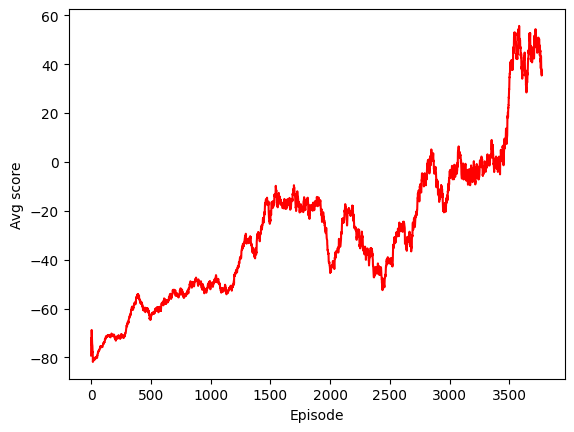

In [28]:
plt.plot(avg_score_history, color = 'red')
plt.xlabel('Episode')
plt.ylabel('Avg score')
# plt.savefig('td3_bipedal_walker_hard.png')

In [26]:
agent.critic_eval_1.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/critic_eval_1.keras')
agent.critic_eval_2.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/critic_eval_2.keras')
agent.critic_target_1.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/critic_target_1.keras')
agent.critic_target_2.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/critic_target_2.keras')
agent.actor_eval.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/actor_eval.keras')
agent.actor_target.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/actor_target.keras')

# saving the score
np.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/score_history.npy', score_history)
np.save('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/avg_score_history.npy', avg_score_history)

In [27]:
# save the experience replay memory
with open('../../docs/td3_bipedal_walker/td3_hard_models/episode 3773/memory.pkl', 'wb') as file:
    pickle.dump(agent.memory, file)